<a href="https://colab.research.google.com/github/gshreya5/colab/blob/main/data_analyzing_british_airways_customer_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis on ✈️ British Airways Customer Reviews
to gain company insights

**GOAL** : Customers who book a flight with BA will experience many interaction points with the BA brand. Understanding a customer's feelings, needs, and feedback is crucial for any business, including BA.

We will be  scraping customer feedback data from Skytrax.com and analyzing the data to uncover insights about the airline.

# Load Libraries

In [139]:
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from  requests import get
from warnings import warn

from nltk.sentiment import vader
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

%matplotlib inline

# Scrape data from [Skytrax](https://www.airlinequality.com/airline-reviews/british-airways/)


In [20]:
database = []

In [22]:
pagesize = 100

for pageno in range(1,36):

  url = f"https://www.airlinequality.com/airline-reviews/british-airways/page/{pageno}/?sortby=post_date%3ADesc&pagesize={pagesize}"
  page = get(url)

  if page.status_code != 200:
    warn(f" Requests: {page} ; Status code: {page.status_code}")

  soup = BeautifulSoup(page.text, 'lxml')
  reviews = soup.find_all('article',{'itemprop':'review'})

  for rev in reviews:
    dic = {"rating" : np.nan, "verified" : np.nan , "full_review" : np.nan  }

    # get rating 
    if rev.find('span',{'itemprop':'ratingValue'}):
      dic['rating'] = rev.find('span',{'itemprop':'ratingValue'}).text

    # get div class = tc_mobile
    div = rev.find('div', class_='tc_mobile')

    #get verication status, review  from div class = text_content
    content=(div.find('div',class_='text_content').text.split('|'))
    if len(content)==2:
            dic["verified"],dic['full_review'] = content
    else:
          dic['full_review'] = content[0]

    # get table data
    table = div.find('table', class_='review-ratings')

    for row in table.find_all('tr'):
      header = row.find('td', class_='review-rating-header').text

      if header in ['Wifi & Connectivity','Value For Money','Seat Comfort','Cabin Staff Service','Food & Beverages','Inflight Entertainment','Ground Service']:
        value = len(row.find_all('span', class_='star fill'))
      else:
        value = row.find('td', class_='review-value').text

      dic[header] = value
    
    database.append(dic)


# Load Data 

In [24]:
dataframe =  pd.DataFrame(database)

In [28]:
df = pd.DataFrame(database)
df.head(2)

,rating,verified,full_review,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Aircraft,Inflight Entertainment,Wifi & Connectivity
0,3,Not Verified,It seems that there is a race to the bottom a...,Couple Leisure,Economy Class,Johannesburg to Los Angeles via London,January 2023,2.0,2.0,2.0,1.0,2,no,NaN,NaN,NaN
1,2,Not Verified,As a Spanish born individual living in Engla...,Solo Leisure,Economy Class,London Gatwick to Alicante,January 2023,NaN,NaN,NaN,NaN,1,no,NaN,NaN,NaN


In [29]:
df.shape

(3460, 16)

In [27]:
df.columns

Index(['rating', 'verified', 'full_review', 'Type Of Traveller', 'Seat Type',
       'Route', 'Date Flown', 'Seat Comfort', 'Cabin Staff Service',
       'Food & Beverages', 'Ground Service', 'Value For Money', 'Recommended',
       'Aircraft', 'Inflight Entertainment', 'Wifi & Connectivity'],
      dtype='object')

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   rating                  3456 non-null   object        
 1   verified                1937 non-null   object        
 2   full_review             3460 non-null   object        
 3   Type Of Traveller       2690 non-null   object        
 4   Seat Type               3458 non-null   object        
 5   Route                   2686 non-null   object        
 6   Date Flown              2682 non-null   datetime64[ns]
 7   Seat Comfort            3360 non-null   float64       
 8   Cabin Staff Service     3352 non-null   float64       
 9   Food & Beverages        3124 non-null   float64       
 10  Ground Service          2622 non-null   float64       
 11  Value For Money         3460 non-null   int64         
 12  Recommended             3460 non-null   object  

 # Data Cleaning

In [35]:
df.isna().sum()

rating                       4
verified                  1523
full_review                  0
Type Of Traveller          770
Seat Type                    2
Route                      774
Date Flown                 778
Seat Comfort               100
Cabin Staff Service        108
Food & Beverages           336
Ground Service             838
Value For Money              0
Recommended                  0
Aircraft                  1651
Inflight Entertainment    1026
Wifi & Connectivity       2946
dtype: int64

In [211]:
df['Date Flown'] = pd.to_datetime(df['Date Flown'])#.dt.strftime('%Y-%m')

In [123]:
df['verified'] = df['verified'].apply(
    lambda val: "Not Verified" if val in ['Not Verified ','❎ Not Verified ','❎ Unverified '] else val)

In [124]:
df.verified.unique()

array(['Not Verified', '✅ Trip Verified ', nan, '✅ Verified Review '],
      dtype=object)

In [63]:
df[df.verified == 'We travelled economy from Manchester to Toronto via Heathrow The flight from Manchester to Heathrow and return was very good. The seats had plenty of room and it was easy to fit laptop size briefcases under the seat in front and still have room to stretch your legs. The service from the cabin crew was excellent. The leg from Heathrow to Toronto was not as comfortable but it was acceptable. The seats appeared narrower and my case only just fit under the seat leaving little room to stretch my legs. Whilst the cabin crew forgot requests for drinks they apologised and were very friendly and helpful in other aspects. Unfortunately BA were let down by the attendants on the return leg from Toronto to Heathrow. Whilst the aircraft appeared newer and more comfortable I have never experienced such surly behaviour from the cabin crew. We had seen attendants in the opposite aisle offering passengers water from trays they were carrying but the attendants down our aisle did not do this. The lady in the seat next to me asked for a glass of water before take off. The steward was quite off hand and said he would bring her one in a minute. He did not do this and when she asked again she was told in a very rude manner that take off procedures took priority otherwise non of us were going anywhere. Even after take off she had to ask again. When they served dinner my daughter did not want a meal but she asked if she could just have the bottle of water that was served with it. The steward said that if she did not want the meal she could not have the water but that he would bring her some in a glass later. This had not appeared by the time I had finished eating my meal so I gave her the bottle from mine (My daughter has a medical condition that requires her to drink water frequently throughout the day) Shortly before landing we were served a muffin and a drink. The passengers on the other aisle were served about 15 mins earlier and they were handed paper napkins and cutlery whilst when we were served we were simply handed the muffin wrapped in cellophane but no plate or napkin to catch the crumbs. I asked for a glass of orange and a tea (as I had not drunk anything on the 6 hour flight). The attendant scowled at me and then gave me half a glass of orange and half a cup of tea (which was cold']

,rating,verified,full_review,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Aircraft,Inflight Entertainment,Wifi & Connectivity,verified1
3081,4,We travelled economy from Manchester to Toront...,) I did not see the attendants down our aisle ...,NaN,Economy Class,NaN,NaN,4.0,2.0,2.0,NaN,4,no,NaN,2.0,NaN,no


In [77]:
df.iloc[3081,2] = df.iloc[3081,1] + df.iloc[3081,2]
df.iloc[3081,1] = 'Not Verified'

In [125]:
df.verified.value_counts()

✅ Trip Verified       972
✅ Verified Review     770
Not Verified          195
Name: verified, dtype: int64

# Data Visualization

## Seat Comfort

In [174]:
px.violin(df,
             x = 'Seat Type',
             y = 'Seat Comfort',
             )

Satisfaction with seats does seem to be increasing as you pay more 

## Date

In [229]:
px.histogram(df,x='Date Flown')

Data shows the trend that flights decreased during 2020, 2021 due to Covid and 

seems to have increased but not as much as Pre Covid

## Route

In [244]:
px.scatter(df,
        x = 'Date Flown',
        y = 'Route', )

Routes flown have decreased over time, 
this could be due to routes being suspended by BA. We need more Data to say anything conclusively.

## Sentiment Analysis

In [112]:
nltk.download('vader_lexicon')

# an instance of SentimentIntensityAnalyzer
sentiment_analyzer = vader.SentimentIntensityAnalyzer()

df['sentiment'] = df['full_review'].apply(
    lambda review: sentiment_analyzer.polarity_scores(review)['compound']
    )

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [113]:
df['sentiment_type'] =  df['sentiment'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
    )

In [246]:
# calculate the percentage of each type of sentiment
sentiment_type_percentages = df['sentiment_type'].value_counts(normalize=True) * 100

px.pie(
    sentiment_type_percentages,
    values = sentiment_type_percentages,
    names=sentiment_type_percentages.index,
    color_discrete_sequence=px.colors.sequential.RdBu ,
    title = 'Sentiment Analysis of BA Airways'
    )

## Recommendation

In [245]:
px.histogram(df,
             x = 'sentiment_type',
             color = 'Recommended',
             )

About a third of positive reviewers said they would not recommend BA. Maybe reviews were not filled diligently.

In [116]:
df['sentiment_type'].value_counts()

positive    2074
negative    1377
neutral        9
Name: sentiment_type, dtype: int64

Pie chart shows majority of reviews were polarised as either positive with about 60% of the reviews  or negative with about 40% of the reviews.



## Topic Modelling with frequency filter

In [145]:
from collections import Counter

nltk.download('stopwords')

# The frequency chart shows the key topics within the 
# reviews showing what people are actively talking about their experience and staff

# Get the reviews from the dataframe
reviews = df['full_review']

# Convert the reviews to a list of words
words = []
for review in reviews:
    words.extend(review.split())

# Filter out the stubborn stop words that don't want to disappear
stopwords = nltk.corpus.stopwords.words('english')
key_words = [word for word in words if word not in stopwords and word not in ['We','I', 'The','would','one','get','-']]

# Get the top 20 most used key words
word_counts = Counter(key_words)
top_20_words = word_counts.most_common(20)

# # Filter out the stop words 
# filtered_words = [
#     (word, count) for word, count in top_20_words if word not in stopwords and word not in ['I', 'The','would','one','get','-']
#     ]

# Get the labels and values for the histogram
labels, values = zip(*top_20_words)

# Create the histogram

px.histogram(x=labels, y=values, title = "Topic Modelling based on Frequency")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The frequency chart below shows that the key topics within the reviews include "flight", "BA", "British", "service" and "seat", showing that people are actively talking about the Airline and their own experience and staff.

## WordCloud

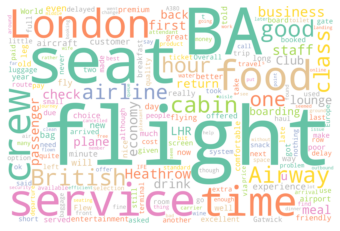

In [152]:
from wordcloud import WordCloud

wordcloud = WordCloud(random_state=42,
                      width=3000,
                      height=2000,
                      colormap="Set2",
                      collocations=False,
                      background_color="white").generate(' '.join(df['full_review']))

# Show the word cloud
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()

Word cloud also showed similar words and key topics within the reviews. This includes "flight", "BA", "seat", "service", showing that people are actively talking about the Airlines and their experience and the staff.